## Exercise 6(a): Polynomial Regression to Predict Wage Using Age

Optimal polynomial degree (by cross-validation): 5


c:\Users\Aidan\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


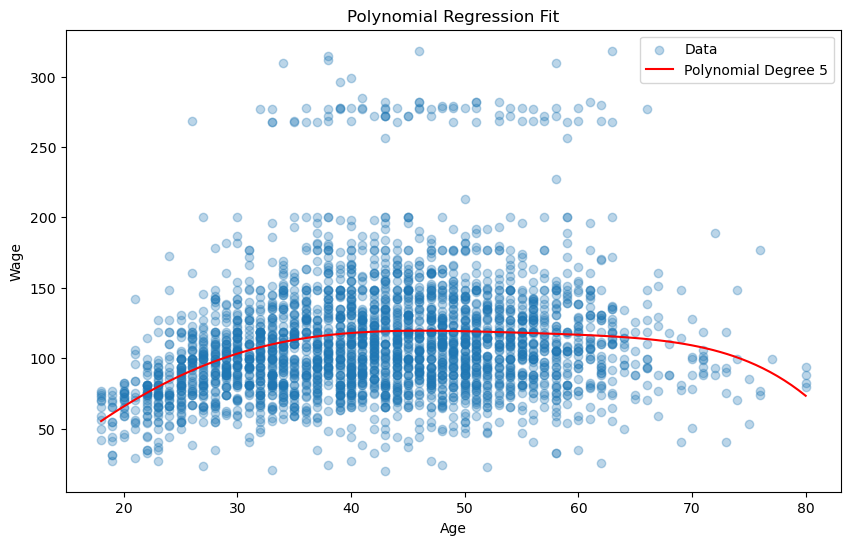

In [2]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error
from statsmodels.formula.api import ols
import statsmodels.api as sm

# Load the Wage data set
wage = pd.read_csv('Wage.csv')

# Drop NA values in case they exist
wage = wage.dropna(subset=['age', 'wage'])

# Prepare X and y
X = wage[['age']]
y = wage['wage']

# Try polynomial degrees 1 to 5 with cross-validation
cv = KFold(n_splits=10, shuffle=True, random_state=1)
degrees = range(1, 6)
cv_errors = []

for d in degrees:
    poly = PolynomialFeatures(degree=d)
    X_poly = poly.fit_transform(X)
    model = LinearRegression()
    # Negative MSE to positive for easier interpretation
    mse = -cross_val_score(model, X_poly, y, scoring='neg_mean_squared_error', cv=cv).mean()
    cv_errors.append(mse)

# Find the best degree
best_degree = degrees[np.argmin(cv_errors)]

print(f"Optimal polynomial degree (by cross-validation): {best_degree}")

# Fit the best polynomial and plot the fit
poly = PolynomialFeatures(degree=best_degree)
X_poly = poly.fit_transform(X)
model = LinearRegression()
model.fit(X_poly, y)

age_grid = np.linspace(X.age.min(), X.age.max(), 100).reshape(-1, 1)
age_grid_poly = poly.transform(age_grid)
preds = model.predict(age_grid_poly)

plt.figure(figsize=(10, 6))
plt.scatter(X, y, alpha=0.3, label='Data')
plt.plot(age_grid, preds, color='red', label=f'Polynomial Degree {best_degree}')
plt.xlabel('Age')
plt.ylabel('Wage')
plt.title('Polynomial Regression Fit')
plt.legend()
plt.show()

In [3]:
# Compare degrees using ANOVA with statsmodels
import patsy

# Fit models for degrees 1 to 5
models = []
for d in degrees:
    formula = 'wage ~ ' + ' + '.join([f'np.power(age, {i})' for i in range(1, d+1)])
    models.append(ols(formula, data=wage).fit())

# Compare using ANOVA
anova_results = sm.stats.anova_lm(*models, typ=1)
display(anova_results)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,2998.0,5.022216e+06,0.0,NaN,NaN,NaN
1,2997.0,4.793430e+06,1.0,228786.010128,143.593107,2.363850e-32
2,2996.0,4.777674e+06,1.0,15755.693664,9.888756,1.679202e-03
3,2995.0,4.771604e+06,1.0,6070.152124,3.809813,5.104620e-02
4,2994.0,4.770322e+06,1.0,1282.563017,0.804976,3.696820e-01


## Exercise 6(b): Step Function to Predict Wage Using Age

Optimal number of cuts (by cross-validation): 8


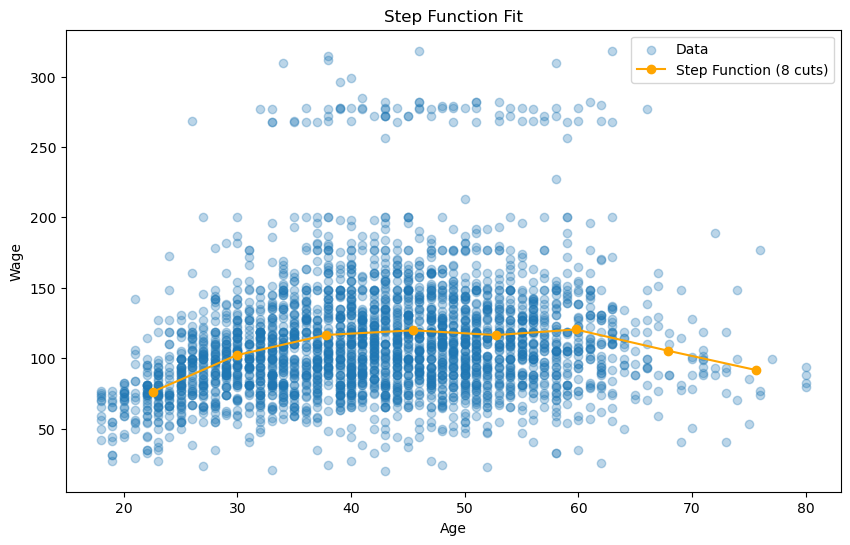

In [4]:
from sklearn.tree import DecisionTreeRegressor

# Try different number of bins (cuts)
cuts = range(2, 11)
cv_errors_step = []

for k in cuts:
    # Bin the age variable
    wage['age_bin'] = pd.cut(wage['age'], bins=k, labels=False)
    # One-hot encode bins for regression
    X_bin = pd.get_dummies(wage['age_bin'])
    mse = -cross_val_score(LinearRegression(), X_bin, y, scoring='neg_mean_squared_error', cv=cv).mean()
    cv_errors_step.append(mse)

# Optimal number of cuts
best_cuts = cuts[np.argmin(cv_errors_step)]
print(f"Optimal number of cuts (by cross-validation): {best_cuts}")

# Fit and plot step function
wage['age_bin'] = pd.cut(wage['age'], bins=best_cuts, labels=False)
X_bin = pd.get_dummies(wage['age_bin'])
model_step = LinearRegression()
model_step.fit(X_bin, y)
step_preds = model_step.predict(X_bin)

plt.figure(figsize=(10, 6))
plt.scatter(wage['age'], wage['wage'], alpha=0.3, label='Data')
# Plot average wage per bin
bin_centers = wage.groupby('age_bin')['age'].mean()
bin_means = wage.groupby('age_bin')['wage'].mean()
plt.plot(bin_centers, bin_means, color='orange', marker='o', label=f'Step Function ({best_cuts} cuts)')
plt.xlabel('Age')
plt.ylabel('Wage')
plt.title('Step Function Fit')
plt.legend()
plt.show()